In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
import matplotlib as mpl
import os
from scipy.io import loadmat

get_dir = os.getcwd()
os.chdir(get_dir)

np.random.seed(1234)

2024-12-09 12:51:54.125151: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-09 12:51:54.125183: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-09 12:51:54.126422: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-09 12:51:54.132569: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-09 12:51:54.743969: W tensorflow/comp

In [2]:
def get_fvalues(x, y, nue):
    
    zeta = (0.5 / nue) - np.sqrt((1 / (4 * nue ** 2)) + 4 * np.pi ** 2)

    u_val = 1 - np.exp(zeta * x) * np.cos(2 * np.pi * y)
    v_val = (zeta / (2 * np.pi)) * np.exp(zeta * x) * np.sin(2 * np.pi * y)
    p_val = 0.5 * (1 - np.exp(2 * zeta * x))

    return u_val, v_val, p_val

def get_predictions(model, test_data):
    
    u_test, v_test, p_test = model.predict(test_data, batch_size=4096)
    return u_test, v_test, p_test
def get_repeated_tensors(x, y, u, v, p, num_samples):
    return (np.repeat(x.reshape((1, -1)), num_samples, axis=0), 
           np.repeat(y.reshape((1, -1)), num_samples, axis=0),
           np.repeat(u.reshape((1, -1)), num_samples, axis=0),
           np.repeat(v.reshape((1, -1)), num_samples, axis=0),
           np.repeat(p.reshape((1, -1)), num_samples, axis=0))

In [3]:
def get_true_test_values(model, nue, xlim, ylim, grid_size, seq_dir, TP=True):
    
    true_val = []
    pred_val = []
    u_val = {'true': [], 'pred': []}
    v_val = {'true': [], 'pred': []}
    
    xdisc = np.linspace(start=xlim[0], stop=xlim[1], num=grid_size)
    ydisc = np.linspace(start=ylim[0], stop=ylim[1], num=grid_size)
    
    X, Y = np.meshgrid(xdisc, ydisc)
    grid_loc = np.hstack((X.flatten()[:, None], Y.flatten()[:, None]))
    coord_val = pd.read_csv(seq_dir)
    x_seq, y_seq = coord_val['0'].values, coord_val['1'].values
    
    for i in nue:
        u_seq, v_seq, p_seq = get_fvalues(x_seq, y_seq, nue=i)
        xbc, ybc, ubc, vbc, pbc = get_repeated_tensors(x_seq, y_seq, u_seq, v_seq, p_seq, num_samples=len(grid_loc))
        if TP:
            test_data = [grid_loc[:, 0:1], grid_loc[:, 1:], xbc, ybc, ubc, vbc, pbc]
        else:
            test_data = [grid_loc[:, 0:1], grid_loc[:, 1:], ubc, vbc, pbc]
        
        u_test, v_test, p_test = get_predictions(model, test_data)
        
        u_test = u_test.reshape(X.shape)
        v_test = v_test.reshape(X.shape)
    
        u_true, v_true, p_true = get_fvalues(x=grid_loc[:, 0:1], y=grid_loc[:, 1:], nue=i)
        
        u_true = u_true.reshape(X.shape)
        v_true = v_true.reshape(X.shape)
        
        true_mag = (u_true ** 2 + v_true ** 2)**0.5
        pred_mag = (u_test ** 2 + v_test ** 2)**0.5
        
        true_val.append(true_mag)
        pred_val.append(pred_mag)
        
        u_val['true'].append(u_true)
        u_val['pred'].append(u_test)
        v_val['true'].append(v_true)
        v_val['pred'].append(v_test)
        
    return X, Y, true_val, pred_val, u_val, v_val

In [4]:
def get_plots(x, y, true_val, pred_val, u_val, v_val, grid_spec, plot_title, plot_save, 
              plot_dir, fig_size,shrink=1, dm=False, lxd = [0.5, 0.5],lyd=[0.1, 0.9], 
              lx=0.25, rx=0.75, text_y=0.9, clim=[0., 4.5], eclim = [0., 0.035], 
              lbs=['PINTO Prediction \n Y', 'Analytical Solution \n Y', 'Relative Error \n Y'], 
              dt=['Seen', 'Unseen'], cbar_kwargs=None, value=None):
    
    fig, ax = plt.subplots(3, len(true_val),figsize=fig_size, sharex='col', sharey='row', 
                           gridspec_kw =grid_spec)
    
    # Create two GridSpec objects for left and right sections
    gs = mpl.gridspec.GridSpec(4, 4, figure=fig)
    
    def fmt(x, pos):
        return f'{x:.1e}'
    level = np.linspace(clim[0], clim[1], num=10)
    err_level = np.linspace(eclim[0], eclim[1], num=10)
    
    for j in range(len(true_val)):
     
        pres = ax[0][j].streamplot(x, y, u_val['pred'][j], v_val['pred'][j], color='k', 
                                    linewidth=0.5)
        pre = ax[0][j].contourf(x, y, pred_val[j], level, cmap='rainbow')

        trus = ax[1][j].streamplot(x, y, u_val['true'][j], v_val['true'][j], color='k', 
                                    linewidth=0.5)
        ref = ax[1][j].contourf(x, y, true_val[j], level, cmap='rainbow')
        
        rel_err = abs(true_val[j] - pred_val[j])/(1 + abs(true_val[j]))
        
        if dm:
            er = ax[2][j].contourf(x, y, rel_err, err_level, cmap='Blues', extend='both')
            er.cmap.set_under('orange')
            er.cmap.set_over('orange')
        else:
            er=ax[2][j].contourf(x, y, rel_err, err_level, cmap='Blues')
        
        ax[0][j].set_title(plot_title[0][j],fontsize=10, fontweight='bold')
        ax[0][j].set_xlim(xlim[0], xlim[1])
        ax[0][j].set_ylim(ylim[0], ylim[1])

        ax[1][j].set_xlim(xlim[0], xlim[1])
        ax[1][j].set_ylim(ylim[0], ylim[1])
        
        ax[2][j].set_xlabel('X', fontsize=10, fontweight='bold')

        for row in ax:
            row[j].set_aspect(value, adjustable='box')

    pcbar = fig.colorbar(pre, ax=ax[0, :], **cbar_kwargs)
    pcbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.2f'))
    pcbar.set_label('|V| (non-dim)', fontsize=10, fontweight='bold')
    
    tcbar = fig.colorbar(ref, ax=ax[1, :], **cbar_kwargs)
    tcbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.2f'))
    tcbar.set_label('|V| (non-dim)', fontsize=10, fontweight='bold')
    
    ecbar = fig.colorbar(er, ax = ax[2, :], **cbar_kwargs)
    ecbar.formatter = tick.FuncFormatter(fmt)
    ecbar.update_ticks()
    
    ax[0][0].set_ylabel(lbs[0], fontsize=10, fontweight='bold')
    ax[1][0].set_ylabel(lbs[1], fontsize=10, fontweight='bold')
    ax[2][0].set_ylabel(lbs[2], fontsize=10, fontweight='bold')

    fig.text(lx, text_y, dt[0], ha='center', va='center', fontsize=12, fontweight='bold')
    fig.text(rx, text_y, dt[1], ha='center', va='center', fontsize=12, fontweight='bold')

    # Add vertical line using figure coordinates
    line = plt.Line2D(lxd, lyd, transform=fig.transFigure, color='black', linewidth=2)
    fig.add_artist(line)
    
    if plot_save:
        plt.savefig(plot_dir + '.png', dpi=300, bbox_inches = 'tight', format='png')

## Figure_7: kovasznay Flow 

In [5]:
PINTO_model = keras.models.load_model('../Trained_models/KF_PINTO/KF_PINTO_model/')

train_test_nue = [1/20, 1/50, 1/15, 1/25]
xlim = [-0.5, 1.0]
ylim = [-0.5, 1.5]
grid_size = 64
seq_dir = '../Trained_models/KF_PINTO/seq_data.csv'

x, y, tno_true, tno_pred, tno_u_val, tno_v_val = get_true_test_values(
    model=PINTO_model, nue=train_test_nue, 
    xlim=xlim, ylim=ylim, grid_size=grid_size, seq_dir=seq_dir)

2024-12-09 12:51:59.964717: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 47184 MB memory:  -> device: 0, name: Quadro RTX 8000, pci bus id: 0000:17:00.0, compute capability: 7.5
2024-12-09 12:51:59.966071: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 47172 MB memory:  -> device: 1, name: Quadro RTX 8000, pci bus id: 0000:65:00.0, compute capability: 7.5


1/1 [==============================] - 0s 25ms/step


2024-12-09 12:52:02.143083: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1/1 [==============================] - 0s 24ms/step


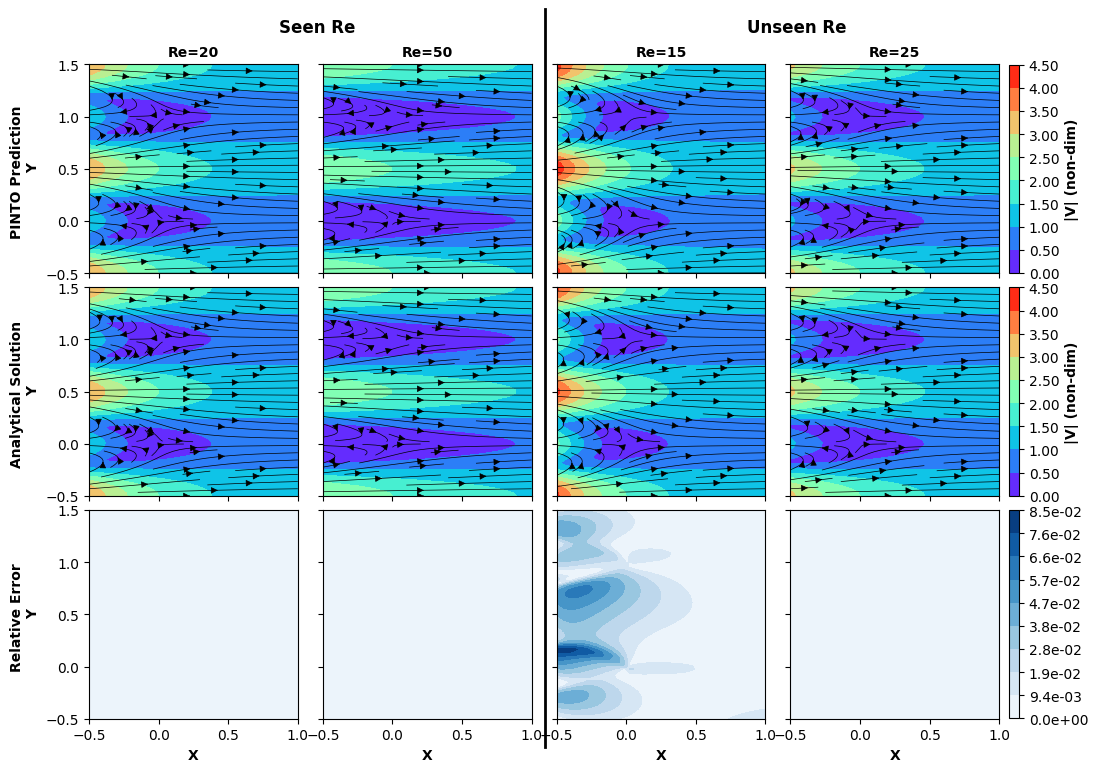

In [6]:
pdir = 'Figure_7'
pt = [['Re=20', 'Re=50', 'Re=15', 'Re=25']]
cbar_kwargs = {
        'fraction': 0.0112, 
        'pad': 0.01,
        'format': tick.FormatStrFormatter('%.2f')
    }

grid_spec = {'wspace': 0.12, 'hspace': -0.1, 'width_ratios':[1, 1, 1, 1], 'height_ratios':[1, 1, 1]}
get_plots(x,  y, true_val=tno_true, pred_val=tno_pred, u_val=tno_u_val, v_val=tno_v_val, 
          plot_save=True, grid_spec=grid_spec, plot_title=pt, plot_dir=pdir, fig_size=(12,9), shrink=1,
          lxd=[0.505, 0.505], lyd=[0.1, 0.92], lx=0.315, rx=0.715, text_y=0.9, clim=[0., 4.5], eclim=[0., 0.085],
          lbs=['PINTO Prediction \n Y', 'Analytical Solution \n Y', 'Relative Error \n Y'], 
	  dt=['Seen Re', 'Unseen Re'], cbar_kwargs=cbar_kwargs, value=1.5/2.)

## PI-DeepONet Plots

In [7]:
pid_model = keras.models.load_model('../Trained_models/KF_DeepONet/KF_Deeponet_model.keras')

seq_dir = '../Trained_models/KF_DeepONet/seq_data.csv'


x, y, pid_true, pid_pred, pid_u_val, pid_v_val = get_true_test_values(
    model=pid_model, nue=train_test_nue, 
    xlim=xlim, ylim=ylim, grid_size=grid_size, seq_dir=seq_dir, TP=False)

1/1 [==============================] - 0s 23ms/step


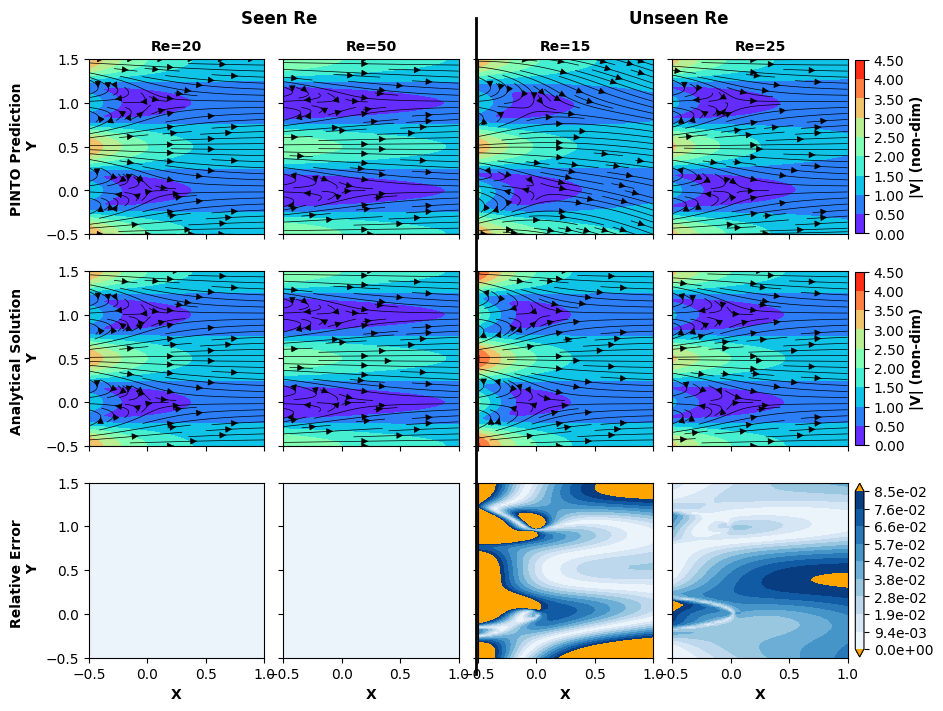

In [8]:
pdir = 'PI_DeepONets_Kovasznay_training_testing_plots'
pt = [['Re=20', 'Re=50', 'Re=15', 'Re=25']]
cbar_kwargs = {
        'fraction': 0.0112, 
        'pad': 0.01,
        'format': tick.FormatStrFormatter('%.2f')
    }

grid_spec = {'wspace': 0.11, 'hspace': 0.1, 'width_ratios':[1, 1, 1, 1], 'height_ratios':[1, 1, 1]}
get_plots(x,  y, true_val=pid_true, pred_val=pid_pred, u_val=pid_u_val, v_val=pid_v_val, 
          plot_save=True, grid_spec=grid_spec, plot_title=pt, plot_dir=pdir, fig_size=(10,8), shrink=1, dm=True,
          lxd=[0.512, 0.512], lyd=[0.1, 0.92], lx=0.315, rx=0.715, text_y=0.92, clim=[0., 4.5], eclim=[0., 0.085],
          lbs=['PINTO Prediction \n Y', 'Analytical Solution \n Y', 'Relative Error \n Y'], 
	  dt=['Seen Re', 'Unseen Re'], cbar_kwargs=cbar_kwargs, value=1.5/2.)

## Tabl1: Performance metrics

In [9]:
training_nue = [1/20, 1/30, 1/50, 1/80]
testing_nue = 1/np.random.uniform(low=10., high=100., size=[1, 20]).reshape(-1)

In [10]:
def get_metrics(true_val, pred_val):
    rel_err = abs(np.concatenate(true_val, axis=0) - np.concatenate(pred_val, axis=0))/(1 + abs(np.concatenate(true_val)))
    mean_metric = np.mean(rel_err)
    std_metric = np.std(rel_err)
    
    return mean_metric, std_metric


In [11]:
sens_dir = '../Trained_models/KF_PINTO/seq_data.csv'

_, _, tno_train_true, tno_train_pred, tno_tr_u_val, tno_tr_v_val = get_true_test_values(
    model=PINTO_model, nue=training_nue, 
    xlim=xlim, ylim=ylim, grid_size=grid_size, seq_dir=seq_dir)

_, _, tno_test_true, tno_test_pred, tno_ts_u_val, tno_ts_v_val = get_true_test_values(
    model=PINTO_model, nue=testing_nue, 
    xlim=xlim, ylim=ylim, grid_size=grid_size,seq_dir=seq_dir)

1/1 [==============================] - 0s 23ms/step


In [12]:
sens_dir = '../Trained_models/KF_DeepONet/seq_data.csv'

_, _, pid_train_true, pid_train_pred, pid_tr_u_val, pid_tr_v_val = get_true_test_values(
    model=pid_model, nue=training_nue, 
    xlim=xlim, ylim=ylim, grid_size=grid_size, seq_dir=seq_dir, TP=False)

_, _, pid_test_true, pid_test_pred, pid_ts_u_val, pid_ts_v_val = get_true_test_values(
    model=pid_model, nue=testing_nue, 
    xlim=xlim, ylim=ylim, grid_size=grid_size,seq_dir=seq_dir, TP=False)

1/1 [==============================] - 0s 25ms/step


In [13]:
print("PINTO Metrics")

train_mean_metric, train_std_metric = get_metrics(tno_train_true, tno_train_pred)
test_mean_metric, test_std_metric = get_metrics(tno_test_true, tno_test_pred)

print("mean relative error across all training sets is: ",train_mean_metric)
print("std of relative error across training sets is: ",train_std_metric)
print("mean relative error across all testing sets is: ",test_mean_metric)
print("std of relative error across testing sets is: ",test_std_metric)

PINTO Metrics
mean relative error across all training sets is:  0.00037697202483356695
std of relative error across training sets is:  0.0003254653367922852
mean relative error across all testing sets is:  0.004103043835785171
std of relative error across testing sets is:  0.025485505200737828


In [14]:
print("PI-DeepONets Metrics")

train_mean_metric, train_std_metric = get_metrics(pid_train_true, pid_train_pred)
test_mean_metric, test_std_metric = get_metrics(pid_test_true, pid_test_pred)

print("mean relative error across all training sets is: ",train_mean_metric)
print("std of relative error across training sets is: ",train_std_metric)
print("mean relative error across all testing sets is: ",test_mean_metric)
print("std of relative error across testing sets is: ",test_std_metric)

PI-DeepONets Metrics
mean relative error across all training sets is:  0.0008049642482501521
std of relative error across training sets is:  0.0006673132236095446
mean relative error across all testing sets is:  0.022576299954881036
std of relative error across testing sets is:  0.0654768795307782
